In [1]:
import pandas as pd
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
df = pd.read_csv('../data/processed/train/data.csv', low_memory=False)
df_val = pd.read_csv('../data/processed/val/data.csv', low_memory=False)
df.head()

,file,superflux,timestamps,energy,rms,sound_preassure_level,welch,mean,kurtosis,skew,variation,onset
0,Media-105913(10.6-20.6),0.00000,0.025,55467400.0,2.98397,-15.84936,759233.5,0.21315,0.70625,0.18791,44.15271,False
1,Media-105913(10.6-20.6),0.00002,0.075,69169704.0,6.24302,-13.66481,6618254.5,0.00680,1.25806,-0.22809,87.05717,False
2,Media-105913(10.6-20.6),0.00002,0.125,40162056.0,200.63614,-10.44240,22182580.0,4.48390,2.54332,-0.05504,-116.18803,False
3,Media-105913(10.6-20.6),0.00002,0.175,12615434.0,466.26970,-10.45462,33959388.0,-44.78118,-0.31614,0.06513,179.42334,True
4,Media-105913(10.6-20.6),0.02186,0.225,10925792.0,480.33290,-12.53607,36534316.0,-43.03605,-0.42523,-0.20142,278.65738,False


In [3]:
df = pd.concat([df, df_val])
df["onset"] = df["onset"].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48899 entries, 0 to 9247
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   file                   48899 non-null  object  
 1   superflux              48899 non-null  float64 
 2   timestamps             48899 non-null  float64 
 3   energy                 48899 non-null  float64 
 4   rms                    48899 non-null  float64 
 5   sound_preassure_level  48899 non-null  float64 
 6   welch                  48899 non-null  float64 
 7   mean                   48899 non-null  float64 
 8   kurtosis               48899 non-null  float64 
 9   skew                   48899 non-null  float64 
 10  variation              48826 non-null  float64 
 11  onset                  48899 non-null  category
dtypes: category(1), float64(10), object(1)
memory usage: 4.5+ MB


In [4]:
train_len = len(df)
splits = (list(range_of(df)[:train_len]),list(range_of(df)[train_len:]))

In [5]:
procs = [Categorify, Normalize]

In [6]:
cont,cat = cont_cat_split(df.loc[:, ~df.columns.isin(['file', 'timestamps', 'sound_preassure_level', 'variation'])], 1, dep_var="onset")

In [7]:
cont

['superflux', 'energy', 'rms', 'welch', 'mean', 'kurtosis', 'skew']

In [89]:
cat

[]

In [8]:
dls = TabularDataLoaders.from_df(df, 
                                 y_names="onset", 
                                 cat_names=cat,
                                 cont_names=cont,
                                 procs=procs,
                                 splits=splits)

In [34]:
TabularDataLoaders.from_df?

Signature:
TabularDataLoaders.from_df(
    df,
    path='.',
    procs=None,
    cat_names=None,
    cont_names=None,
    y_names=None,
    y_block=None,
    valid_idx=None,
    bs=64,
    shuffle_train=None,
    shuffle=True,
    val_shuffle=False,
    n=None,
    device=None,
    drop_last=None,
    val_bs=None,
)
Docstring: Create from `df` in `path` using `procs`
File:      ~/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/fastai/tabular/data.py
Type:      method


In [9]:
#####################
# Construct Weights #
#####################
class_count_df = df.groupby("onset").count()

n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)

# Important: Convert Weights To Float Tensor
class_weights=torch.FloatTensor([w_0, w_1])

In [10]:
class_weights

tensor([0.6846, 1.8545])

In [27]:
loss_func = LabelSmoothingCrossEntropyFlat(weight=class_weights)

In [28]:
learn = tabular_learner(dls, loss_func=loss_func, metrics=[
    accuracy, 
    F1Score(labels=[0,1]), 
    Precision(labels=[0,1]), 
    Recall(labels=[0,1]),
])

In [29]:
learn.summary()

TabularModel (Input shape: 64 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     64 x 200            
Linear                                    1400       True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     64 x 100            
Linear                                    20000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     64 x 2              
Linear                                    202        T

SuggestedLRs(valley=0.001737800776027143)

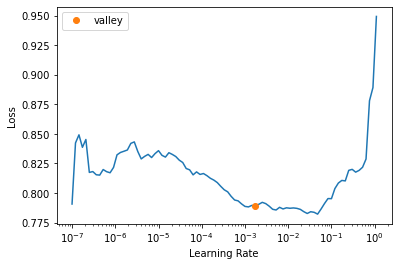

In [30]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(8, 4e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time


AttributeError: Exception occured in `MixUp` when calling event `before_batch`:
	'tuple' object has no attribute 'device'

In [20]:
learn.show_results()

,superflux,energy,rms,welch,mean,kurtosis,skew,onset,onset_pred
0,-0.375481,0.604080,1.954407,-0.303588,0.494267,-0.033431,0.029730,0.0,0.0
1,-0.358944,0.524737,-0.122004,1.759861,0.022770,-0.028779,0.277972,0.0,0.0
2,-0.019515,0.054518,2.573981,-0.479156,0.085574,-0.034751,0.145491,0.0,0.0
3,-0.143112,-0.526454,-1.123926,0.473316,-1.317665,0.019635,-0.077732,0.0,0.0
4,-0.577057,1.764008,1.023584,2.632072,0.212222,-0.036090,0.090354,0.0,0.0
5,-0.510341,2.457729,0.035072,-0.827911,1.238821,-0.037591,0.014464,0.0,0.0
6,5.931833,0.033108,-0.909383,-0.839589,3.051326,-0.036383,-0.163929,0.0,0.0
7,-0.522458,-0.227400,-0.586668,3.590182,-0.170339,-0.041675,-0.020857,0.0,0.0
8,-0.515045,-0.612174,-1.480255,0.332753,0.722333,-0.046197,-0.024240,0.0,0.0


In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.show_results(list(range(8)))

,superflux,energy,rms,welch,mean,kurtosis,skew,onset,onset_pred
0,-0.438469,-0.767734,-0.684212,-0.534231,0.607911,0.040094,-0.069009,0.0,1.0
1,1.518215,0.547596,0.643090,-0.265508,1.096023,-0.038453,0.128871,0.0,1.0
2,-0.552464,-0.428672,0.146118,0.424884,0.054551,-0.042145,-0.083215,1.0,0.0
3,-0.490084,-0.675054,-0.752562,1.247201,-0.429238,-0.037685,-0.283303,0.0,1.0
4,-0.228282,-0.595903,0.042388,0.516294,-0.563131,-0.032642,-0.044480,1.0,1.0
5,3.221101,-0.051119,0.067165,-0.195941,-0.093917,0.002325,0.027748,0.0,1.0
6,-0.471039,-0.788768,-0.775681,-0.722825,-0.405338,-0.006212,0.034698,0.0,1.0
7,-0.494087,-0.611593,0.671164,-0.483155,0.121698,-0.037207,-0.052520,1.0,0.0


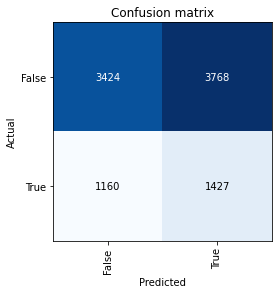

In [26]:
interp.plot_confusion_matrix()

In [23]:
learn.save('tabular')

Path('models/tabular.pth')

In [24]:
learn = learn.load("tabular")

In [25]:
test_df = pd.read_csv('../data/processed/test/data.csv', low_memory=False)
dl = learn.dls.test_dl(test_df)

In [26]:
learn.get_preds(dl=dl)

(tensor([[0.5373, 0.4627],
         [0.5087, 0.4913],
         [0.4924, 0.5076],
         ...,
         [0.4891, 0.5109],
         [0.4145, 0.5855],
         [0.5092, 0.4908]]),
 None)

In [27]:
# decision tree
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [28]:
def rf(xs, y, n_estimators=40, max_samples=train_len,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

m = rf(xs, y);

In [29]:
m

RandomForestRegressor(max_features=0.5, max_samples=19856, min_samples_leaf=5,
                      n_estimators=40, n_jobs=-1, oob_score=True)